In [132]:
# Allow python to import modules from src folders
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
sys.path.append("src/")

from preprocessing.load_dataset import *

SAVE_PATH = "./data/refined"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

# Part 0: Requirements

## Abstract 

In the movie industry, creativity is generally considered to be a key factor in the success of a film. Actors often need to reinvent themselves to keep audiences hooked, but do they really ? Some actors tend to develop a comfort zone and keep playing the same type of movies / characters. Our projects aims at discovering those comfort zones, when they are created and what happens when actors step out of it. Conversly, we also want to evaluate if a given role/character tends to be played only by a subset of actors and which feature/s these actors share, which could lead us to uncover racial or gender biases in film castings. We build on top of the results of the [original paper](http://www.cs.cmu.edu/~ark/personas/) in order to identify in a more fine-grained approach if an actors exhibit a recurring persona accross the characters they play.

## Research questions

1. What is the proportion of actors that tend to play the same type of movies ?
2. When did an actor start to play in similar movies/similar characters ?
3. Do actors exhibit a recurring persona accross the characters they play ?
4. Is there a clear distribution shift in the perfromance of a movie when this actor is/isn't in his comfort zone ?
5. Are there roles that are acclaimed only when they are played by a specific group of actors ?
6. Which features of an actor impact the distribution of his roles ?

## Download data 

In order to download all required datasets, run the cell bellow (may take a while the first time).

In [2]:
%run src/preprocessing/download_dataset.py

[+] Found cached dataset for url https://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.basics.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/name.basics.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.ratings.tsv.gz
[+] Found cached dataset for url https://datasets.imdbws.com/title.principals.tsv.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/25.100.lda.cond.log.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/25.100.lda.log.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/featureFile.txt.gz
[+] Found cached dataset for url https://raw.githubusercontent.com/MichelDucartier/ACL_personas_dump/master/personas/featureMeans.txt.gz
[+] Found cached da

# Part I: Load, explore and join datasets

## CMU dataset

We load the 4 `.tsv` and `.txt` files of the CMU dataset into 4 different dataframes

In [3]:
characters_df = load_characters_df()
movies_df = load_movies_df()
plot_df = load_plot_df()
tvtropes_df = load_tvtropes_df()

### Characters

The characters dataframe comes from the CMU movies dataset. This dataframe describes movie characters and provides information about the actor who played the corresponding character. Here is a sample of this dataframe :

In [4]:
characters_df.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
333946,14683918,/m/03gt0jb,2007,NaN,1986-06-14,F,1.60,NaN,Haley Hudson,20.0,/m/0gckbjw,NaN,/m/0276ryq
403626,159980,/m/0153xc,2001-10-05,NaN,1953-10-15,M,1.80,/m/041rx,Larry Miller,47.0,/m/03l5_wb,NaN,/m/06gb2q
320855,12233793,/m/02vwx4p,1981,NaN,NaN,NaN,NaN,NaN,Jo Livingston,NaN,/m/0gcxd53,NaN,/m/0gcxd56
368839,23739629,/m/06zn7wx,1938,NaN,1890-08-15,F,NaN,NaN,Phyllis Dare,NaN,/m/0glmrrv,NaN,/m/03c5l8v
212303,7334748,/m/0kv5bh,1995,Shekar,1958-09-03,M,1.83,/m/0dryh9k,Shakti Kapoor,36.0,/m/0crx93p,/m/0h88wbn,/m/05yvfd


In [5]:
total_characters = len(characters_df)
print(f"Number of characters loaded: {total_characters}")
print(f"Number of unique movies: {len(characters_df['wiki_movie_id'].unique())}")
print(f"Number of unique actors: {len(characters_df['freebase_actor_id'].unique())}", end="\n\n")

print(f"Percentage of missing gender: {characters_df['actor_gender'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing height: {characters_df['actor_height'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing ethnicity: {characters_df['actor_ethnicity'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing age upon release: {characters_df['release_actor_age'].isna().sum()/total_characters*100:.2f}%", end="\n\n")

print(f"Number of character records for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()])}")
print(f"Number of unique actors for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()]['freebase_actor_id'].unique())}")

Number of characters loaded: 450669
Number of unique movies: 64330
Number of unique actors: 135761

Percentage of missing gender: 10.12%
Percentage of missing height: 65.65%
Percentage of missing ethnicity: 76.47%
Percentage of missing age upon release: 35.08%

Number of character records for which ethnicity is known: 106058
Number of unique actors for which ethnicity is known: 8151


We can first notice that a great percentage of actor's ethnicity is missing. This may become a problem when we study the impact of actors' ethnicity on the success of a movie. Let's investigate a bit.

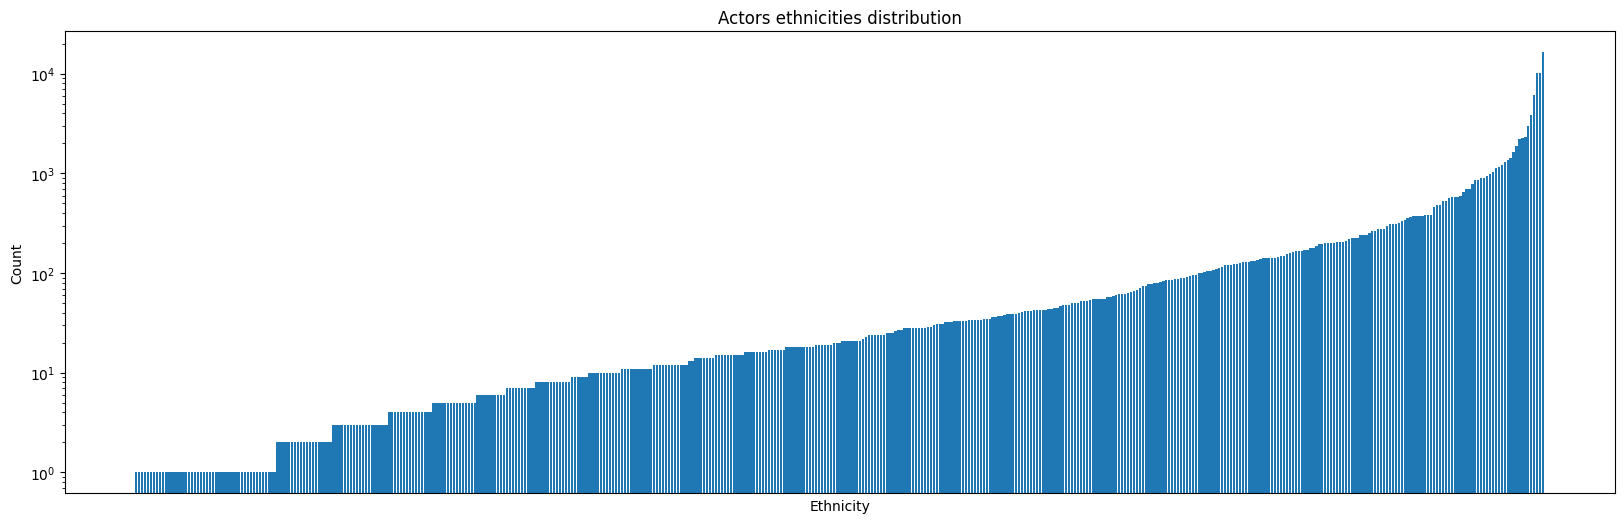

In [6]:
actors_ethnicities = characters_df[['freebase_actor_id', 'actor_ethnicity']].dropna().groupby(by='actor_ethnicity').count()
actors_ethnicities = actors_ethnicities.sort_values(by='freebase_actor_id')

plt.figure(figsize=(20,6))
plt.bar(actors_ethnicities.index, actors_ethnicities['freebase_actor_id'], label='')
plt.title("Actors ethnicities distribution")
plt.yscale('log')
plt.xticks([])
plt.ylabel("Count")
plt.xlabel("Ethnicity")
plt.show()

As shown, the ethnicities distribution is very heterogeneous. Some ethnicities have only one representative whereas others have more than thousands elements. During analysis, we must be careful on our conclusions as variance gets higher for the ethnicities with fewer representatives. Fortunately, we can quantify uncertainty in our results using tools like p-value and confidence interval.

### Movies

The movies dataframe also comes from the CMU dataset and provides information about movies such as its origins, runtime and box office.

In [7]:
movies_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres
21491,27671001,/m/0c41tvs,Eroica,2003-10-04,NaN,129.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/04xvlr': 'Period piece', '/m/07s9rl0': 'D..."
22885,22375407,/m/05sxx6v,Slaughter Trail,NaN,NaN,78.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},{'/m/0hfjk': 'Western'}
80844,21450209,/m/05f6qq7,Separation,NaN,NaN,NaN,{},{'/m/07ssc': 'United Kingdom'},{'/m/07s9rl0': 'Drama'}
35190,30673852,/m/0g9tjnk,Nutcracker,1983-11-17,NaN,101.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},{'/m/07s9rl0': 'Drama'}
69848,18929130,/m/04jn7_8,Cor Blimey!,2000-04-24,NaN,108.0,{'/m/02h40lc': 'English Language'},{'/m/07ssc': 'United Kingdom'},"{'/m/02l7c8': 'Romance Film', '/m/07s9rl0': 'D..."


In [8]:
total_movies = len(movies_df)
print(f"Number of movies loaded: {total_movies}")
print(f"Percentage of missing box office revenue: {movies_df['box_office'].isna().sum()/total_movies*100:.2f}%")
print(f"Number of movies for which we have matching character data: {len(movies_df.merge(characters_df, how='inner', on=['wiki_movie_id', 'freebase_movie_id'])['freebase_movie_id'].unique())}")

Number of movies loaded: 81741
Percentage of missing box office revenue: 89.72%
Number of movies for which we have matching character data: 64330


A great proportion of box office revenue data is missing (almost 90%). This makes sense as lots of movies are not shown in cinemas such as TV movies, short movies. Indeed, to get a movie to the box office, one needs to work with studios or convince distributors to distribute the movie.

Thus, using box office as a way to measure a movie's performance may be biased because we already filter a specific type of movie. Furthermore, box office does not necessarily reflect the quality of a movie. Indeed some movies may not get a high box office revenue because of a lack of advertising. To fix this issue, we will use users rating from the IMDb database.

In [9]:
# Extract years from the release date of movies
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)

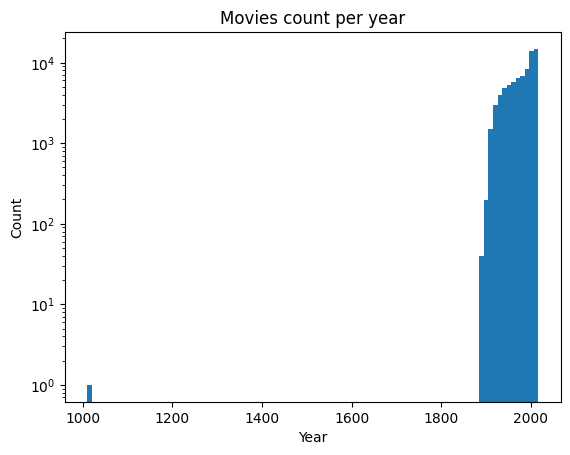

In [10]:
plt.hist(movies_df['movie_release_year'], bins=100)
plt.yscale("log")
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

We notice that a movie has been produced 700 years before the invention of potography ! Let's investigate:

In [11]:
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index
movies_df.loc[wrong_dates]

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{'/m/02hwyss': 'Turkish Language', '/m/02h40lc...",{'/m/01znc_': 'Turkey'},"{'/m/0lsxr': 'Crime Fiction', '/m/02n4kr': 'My...",1010.0


By googling the movie's name, we find that `Hunting season` should be released in 2010 (instead of 1010). This is obviously a typo and 1010 should be replaced by 2010.

In [23]:
# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

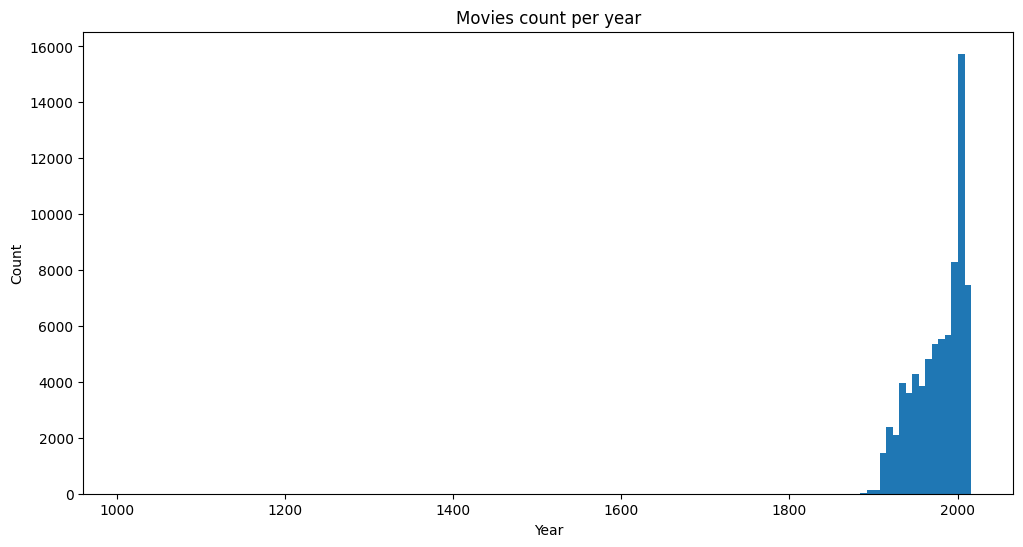

In [13]:
n_years = len(movies_df['movie_release_year'].dropna().unique())

plt.figure(figsize=(12, 6))
plt.hist(movies_df['movie_release_year'], bins=n_years)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

There are significantly more movies released after 1990 than before in our dataset.

### Plot

The plot dataframe comes from the CMU dataset and provides a summary of the plot of a given movie.

In [14]:
plot_df.sample(5)

,wiki_movie_id,plot_summary
37242,30885438,Martel Gordone had been wandering aimlessly th...
31497,6716962,A group of travelers is stranded in a small co...
6112,6003924,Working for the US Government to retrieve a ca...
39563,1791382,Having robbed and thoroughly destroyed a gas s...
13094,18800331,"Like the novel, the story is about artist Thom..."


In [16]:
total_plot = len(plot_df)
print(f"Number of plot summaries loaded: {total_plot}")

Number of plot summaries loaded: 42303


### Tropes

The tvtropes dataframe is the one used by the CMU researchers to validate their personas learning algorithm. Unfortunately, this dataset does not contain a lot of tvtropes and can not be used for our analysis. Thus we need other databases to get the persona of movie characters.

In [17]:
tvtropes_df.sample(5)

,trope_name,character_data
393,psycho_for_hire,"{'char': 'Bullet Tooth Tony', 'movie': 'Snatch..."
119,corrupt_corporate_executive,"{'char': 'Royalton', 'movie': 'Speed Racer', '..."
123,corrupt_corporate_executive,"{'char': 'Ed Dillinger', 'movie': 'Tron', 'id'..."
186,ditz,"{'char': 'Nick', 'movie': '30 Minutes or Less'..."
148,crazy_jealous_guy,"{'char': 'Tommy DeVito', 'movie': 'Goodfellas'..."


In [18]:
total_tropes = len(tvtropes_df)
print(f"Number of tropes loaded: {total_tropes}")

Number of tropes loaded: 501


## IMDB dataset


We need to define a metric of "success" of a film. Even if we are already provided with the `box_office` column in the cmu dataset, it only includes data for the bigger blockbusters, wihch represent only 10% of the movies. We have therefore decided to use the imdb rating of the film as a metric defining its performance.

We also used the `people` and `principals` collections from IMDb to enrich the `characters` collection from the CMU corpus, reducing the amount of missing information.

We load the 4 `.tsv` files of the IMDB dataset into 4 different dataframes

In [19]:
imdb_ratings_df = load_imdb_ratings()
imdb_title_df = load_imdb_title_basics()
imdb_principals_df = load_imdb_title_principals()
imdb_people_df = load_imdb_person_basics()

### Ratings

First let's explore the ratings dataframe.

In [20]:
imdb_ratings_df.sample(5)

,tconst,averageRating,numVotes
364532,tt0718287,1.4,87
884189,tt2186810,9.5,6
284818,tt0541193,5.2,6
121454,tt0180752,5.8,650
240771,tt0439934,6.1,48


We have 1365868 movies for which we have a rating.


C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


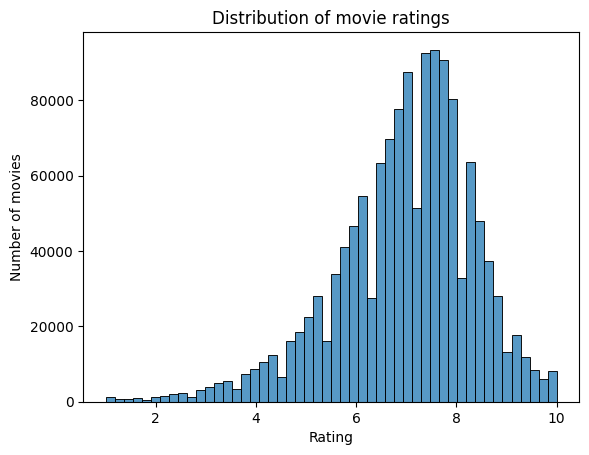

C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


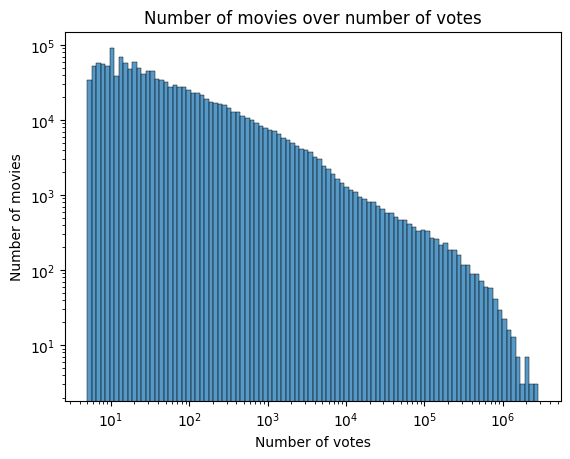

In [21]:
total_ratings = len(imdb_ratings_df)
print(f"We have {total_ratings} movies for which we have a rating.")

# Check the distribution of grades
sns.histplot(data=imdb_ratings_df, x="averageRating", bins=50)

plt.title("Distribution of movie ratings")
plt.xlabel("Rating")
plt.ylabel("Number of movies")
plt.show()

# Check the distribution of votes
sns.histplot(data=imdb_ratings_df, x="numVotes", bins=100, log_scale=True)
plt.yscale("log")

plt.title("Number of movies over number of votes")
plt.xlabel("Number of votes")
plt.ylabel("Number of movies")
plt.show()

### Title

In [23]:
imdb_title_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
169149,tt0175217,movie,Svet otevrený náhodám,Svet otevrený náhodám,0,1971,\N,93,\N
5492441,tt2139721,movie,The Hadza: Last of the First,The Hadza: Last of the First,0,2014,\N,71,Documentary
3660184,tt1493037,movie,North Woods,North Woods,0,2009,\N,\N,Horror
5359963,tt21079976,movie,Daughter,Daughter,0,\N,\N,\N,"Drama,Mystery,Thriller"
7545852,tt3846776,movie,Insepultos,Insepultos,0,\N,\N,\N,Thriller


In [25]:
# Remove adult content
imdb_title_df = imdb_title_df[imdb_title_df["isAdult"].astype(int) == 0]
total_title = len(imdb_title_df)
print(f"We have {total_title} movie titles")

We have 651888 movie titles


### Principals

In [26]:
total_principals = len(imdb_principals_df)
print(f"We have {total_principals} principals records")
print(f"We have {len(imdb_principals_df['category'].unique())} categories")
print(f"We have {len(imdb_principals_df['nconst'].unique())} unique persons", end="\n\n")

missing_characters = len(imdb_principals_df[imdb_principals_df['characters'] == "\\N"])
print(f"We have {missing_characters/total_principals*100:.2f}% of missing characters")


imdb_principals_df.sample(5)

We have 58900432 principals records
We have 12 categories
We have 5169350 unique persons

We have 51.88% of missing characters


,tconst,ordering,nconst,category,job,characters
49330876,tt6418094,6,nm8705844,writer,creator,\N
14998935,tt12254238,1,nm1081425,actress,\N,"[""Ilektra Theoxari""]"
16605198,tt1281185,8,nm1012347,producer,producer,\N
20996352,tt14436340,3,nm4450871,actress,\N,"[""Priya Mohite""]"
45577534,tt4827102,8,nm7428893,cinematographer,\N,\N


### People

In [27]:
total_people = len(imdb_people_df)
print(f"We have {total_people} people records")
print(f"We have {len(imdb_people_df['nconst'].unique())} unique persons")
print(f"We have {len(imdb_people_df[(imdb_people_df['primaryProfession'] == 'actor') | (imdb_people_df['primaryProfession'] == 'actress')])} unique actors")

imdb_people_df.sample(5)

We have 12978070 people records
We have 12978070 unique persons
We have 3862314 unique actors


,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
3178378,nm12375885,Shruti Dandawate,\N,\N,actress,tt14177526
2045360,nm11191215,James Shiflett,\N,\N,actor,tt0235535
8738991,nm4713352,Will Thwaites,\N,\N,"miscellaneous,producer,camera_department","tt2079464,tt5547946,tt28759350,tt8344332"
4903429,nm14241796,Paulette Have,\N,\N,NaN,\N
2944213,nm12128734,Mark Bennett,\N,\N,"editor,cinematographer,camera_department","tt1538441,tt21439488,tt21611398,tt22079344"


### Movie titles with ratings

In [29]:
imdb_title_with_rating = imdb_title_df.merge(imdb_ratings_df, on='tconst', how='inner')

total_movies_w_rating = len(imdb_title_with_rating)
print(f"We have {total_movies_w_rating} movies with ratings")

imdb_title_with_rating.sample(5)

We have 294744 movies with ratings


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
46173,tt0085125,movie,2019: After the Fall of New York,2019 - Dopo la caduta di New York,0,1983,\N,96,"Action,Sci-Fi",5.5,3237
123728,tt0399675,movie,Sophiatown,Sophiatown,0,2003,\N,82,"Documentary,Music",8.3,41
197213,tt1808245,movie,Lambent Fuse,Lambent Fuse,0,2011,\N,99,\N,8.1,23
252125,tt4636252,movie,Gold Digger,Onnenonkija,0,2016,\N,88,Comedy,5.5,566
137544,tt0810049,movie,To Play and to Fight,Tocar y luchar,0,2006,\N,70,Documentary,7.6,100


There is more than one quarter of a million movies for which we have at least one rating. We have clearly much more data to work with than with box office revenue. Furthermore, there is a substantial amount of movies who have at least a few hundreds votes. This will allow us to get better confidence interval and reduce uncertainty in our analysis.

## Merge CMU movies and plot summaries with IMDB titles and ratings

The translation dataframe from wikidata, which includes both the IMDB id and the Freebase id, enables us to combine the IMDB dataset with the CMU dataset

In [30]:
translation_id = load_translation_df()

imdb_title_with_rating_translated = imdb_title_with_rating.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_title_with_rating_translated = imdb_title_with_rating_translated.drop(["imdb_id"], axis=1)

cmu_movies_w_imdb_rating = imdb_title_with_rating_translated.merge(movies_df, how='inner', left_on='freebase_id', right_on='freebase_movie_id').copy()

# Enriching CMU data
# IMDB start year has no missing data, so we insert it into "NaN" fields of "movie_release_date" and drop "startYear"
missing_years = cmu_movies_w_imdb_rating[cmu_movies_w_imdb_rating['movie_release_date'].isna()].index
cmu_movies_w_imdb_rating.loc[missing_years, 'movie_release_date'] = cmu_movies_w_imdb_rating.loc[missing_years, 'startYear']

# We have MANY depulicated attributes
# We evaluated for each pair which column had more missing data and dropped it in favor of the other
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop(["freebase_movie_id", "titleType", "isAdult", "endYear", "primaryTitle", "originalTitle", "movie_release_year", "movie_runtime", "startYear"], axis=1)

cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop_duplicates("tconst")
print(f"The merged dataframe contains {len(cmu_movies_w_imdb_rating)} movies with corresponding ratings")

The merged dataframe contains 44467 movies with corresponding ratings


In [31]:
# Add summaries
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.merge(plot_df, on="wiki_movie_id", how="left")
cmu_movies_w_imdb_rating.sample(5)

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
11846,tt0054923,101,"Comedy,Music,Romance",5.7,1171,/m/091r45,3257858,Gidget Goes Hawaiian,1961,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06cvj': 'Romantic comedy', '/m/04t36': 'M...","{{Plot}} The film opens with Francie ""Gidget"" ..."
8091,tt0043311,104,Comedy,6.7,70,/m/0crdwr6,28467145,Bakonja fra Brne,1951-04-28,NaN,{'/m/0k0sb': 'Serbian language'},{'/m/087vz': 'Yugoslavia'},{'/m/05p553': 'Comedy film'},NaN
33097,tt0323647,97,Drama,6.8,32,/m/09k6_xz,25462251,Las Pirañas aman en Cuaresma,1969,NaN,{'/m/06nm1': 'Spanish Language'},{'/m/0b90_r': 'Mexico'},"{'/m/02kdv5l': 'Action', '/m/03k9fj': 'Adventu...",After the death of her husband who is devoured...
34039,tt0366894,102,"Comedy,Horror",4.2,705,/m/0crz8v1,28280207,Penetration Angst,2003,NaN,{'/m/02h40lc': 'English Language'},"{'/m/07ssc': 'United Kingdom', '/m/0345h': 'Ge...","{'/m/01q03': 'Cult', '/m/0qdzd': 'B-movie', '/...",A shy and sexually frustrated young woman name...
39663,tt1093803,155,"Documentary,Drama,War",6.4,37,/m/0j62g0x,35002655,"Algérie, histoires à ne pas dire",2007-08,NaN,"{'/m/064_8sq': 'French Language', '/m/0jzc': '...","{'/m/0f8l9c': 'France', '/m/0h3y': 'Algeria'}","{'/m/07s9rl0': 'Drama', '/m/0jtdp': 'Documenta...","When independence is declared in 1962, the min..."


## Merge IMDB people and principals
We now focus on characters and actors. We merge the two dataframes from IMDB and keep records of interest i.e for which the movie is in the collection above.

In [32]:
titles_of_interest = cmu_movies_w_imdb_rating["tconst"].to_list()

imdb_actors = imdb_people_df[(imdb_people_df["primaryProfession"].str.contains("actor")) | (imdb_people_df["primaryProfession"].str.contains("actoress"))].copy()
imdb_principals_actors = imdb_principals_df[(imdb_principals_df["category"] == "actress") | (imdb_principals_df["category"] == "actor")].copy()

imdb_actors_and_characters = imdb_actors.merge(imdb_principals_actors, on="nconst", how="inner").copy()
imdb_actors_and_characters = imdb_actors_and_characters[imdb_actors_and_characters["tconst"].isin(titles_of_interest)]
imdb_actors_and_characters = imdb_actors_and_characters.drop(["ordering", "category", "job", "primaryProfession"], axis=1)

In [33]:
imdb_actors_and_characters.sample(5)

,nconst,primaryName,birthYear,deathYear,knownForTitles,tconst,characters
791921,nm0076306,Luc Bernard,\N,\N,"tt0310203,tt0110413,tt0424525,tt0103442",tt0099604,"[""Chiffre N°1""]"
6824105,nm12588532,G. Pattu,\N,\N,tt0254966,tt0254966,\N
3294044,nm0508293,Thierry Lhermitte,1952,\N,"tt0084555,tt2609222,tt0306734,tt0119038",tt0120156,"[""Brice d'Hachicourt""]"
2331307,nm0320876,Kaan Girgin,1967,\N,"tt0782037,tt0448352,tt6369662,tt0200489",tt0782037,\N
1092638,nm0122910,Tommy Burns,1922,2011,tt0041900,tt0041900,"[""Luke O'Riordan""]"


## Filter CMU characters
We keep records of interest in the same fashion as done above

In [35]:
titles_of_interest_wiki = cmu_movies_w_imdb_rating["wiki_movie_id"].to_list()
characters_interest = characters_df[characters_df["wiki_movie_id"].isin(titles_of_interest_wiki)]
characters_interest.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
81584,24234932,/m/07k6tht,1938-05-13,Holo,1910-05-14,M,NaN,NaN,Paul Sutton,27.0,/m/0n5zpyx,/m/0n5zpy_,/m/08vk5h
207895,1492011,/m/055l31,1973-09,NaN,NaN,F,NaN,NaN,Françoise Widhoff,NaN,/m/0hh46fj,NaN,/m/0bfmxxx
44134,16091743,/m/04j2_y3,1973-10-23,NaN,1948-11-09,F,NaN,NaN,Kelly Harmon,24.0,/m/0gc474q,NaN,/m/0gc474t
423375,30877199,/m/05tgdpd,2008-10-04,Marieke,1980-08-15,F,1.549,NaN,Natalie Press,28.0,/m/08db9cw,/m/08db9cz,/m/0ckzg0
170962,20125873,/m/04yggk9,1991-11-15,NaN,1950-07-24,M,NaN,NaN,Sam Behrens,41.0,/m/052g_nm,NaN,/m/09215f


## Merge IMDB actors and characters with CMU characters
We merge IMDB character and actor data with the CMU data. We make use of the translation dataframe again.

In [36]:
imdb_actors_and_characters_translated = imdb_actors_and_characters.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.drop(["imdb_id"], axis=1)

In [37]:
# TODO, currently merging on movie id and actor name. Would rather merge with actor id too but a translation is needed
imdb_actors_w_cmu_characters = imdb_actors_and_characters_translated.merge(characters_interest, how='inner', left_on=['freebase_id', 'primaryName'], right_on=['freebase_movie_id', 'actor_name']).copy()

# Merge birth year information
missing_birth_years = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['actor_birth'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_birth_years, 'actor_birth'] = imdb_actors_w_cmu_characters.loc[missing_birth_years, 'birthYear']

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop(["freebase_movie_id", "primaryName", "deathYear", "birthYear", "character_name"], axis=1)

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop_duplicates()

imdb_actors_w_cmu_characters.sample(5)

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
11084,nm0001191,"tt0120484,tt0120888,tt0185431,tt0142342",tt0343660,"[""Henry Roth""]",/m/02f6g5,477099,2004-02-13,1966-09-09,M,1.78,/m/041rx,Adam Sandler,37.0,/m/0jsll5,/m/02nw9b3,/m/0pz91
49033,nm0474774,"tt4387040,tt0242519,tt5165344,tt3848892",tt1091229,"[""Sidhu""]",/m/05v5_gc,11977088,2009-01-15,1967-09-09,M,1.85,/m/0dryh9k,Akshay Kumar,41.0,/m/040j26g,/m/0gxr9mh,/m/02tq2r
37990,nm0737259,"tt0021759,tt0020490,tt0025335,tt0027042",tt0021759,"[""Hank Martin""]",/m/04zz0tq,18164604,1931-04-06,1879-11-04,M,NaN,/m/0dbxy,Will Rogers,NaN,/m/0dls0x3,NaN,/m/01t7pgk
9406,nm0233027,"tt6723592,tt3920596,tt13111078,tt0439100",tt0278504,"[""Hap Eckhart""]",/m/0cly8m,4760936,2002-05-24,1957-08-19,M,1.85,/m/033tf_,Martin Donovan,44.0,/m/03lkhy2,/m/0cygmgx,/m/08664q
66108,nm0578854,"tt0097076,tt0218937,tt0081858,tt0096664",tt0218937,"[""David Andrews""]",/m/03cn6hr,13919299,1984,\N,M,NaN,NaN,Bob Mendelsohn,NaN,/m/0jvqq4k,/m/0jvqrdw,/m/0gc83y7


## Summary of results for part I
We now have two main dataframes for further analysis. One containing everything related to movies and their ratings and the other containing everything related to actors, their features and characters they played in a given movie.

In [38]:
movies = cmu_movies_w_imdb_rating.copy()
actors_characters = imdb_actors_w_cmu_characters.copy()
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,Romance,5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"Documentary,News,Sport",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"Action,Adventure,Biography",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",NaN
4,tt0000679,120,"Adventure,Fantasy",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",NaN


In [39]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0025164,"[""Guy Holden""]",/m/0glnm,61169,1934,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0,/m/0h953
1,nm0002143,"tt0057193,tt0036613,tt0030241,tt0027125",tt0025164,"[""Egbert 'Pinky' Fitzgerald""]",/m/0glnm,61169,1934,1886-03-18,M,NaN,NaN,Edward Everett Horton,NaN,/m/0cs6brt,NaN,/m/0197p7
2,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0026942,"[""Huck Haines""]",/m/02x5h46,12800555,1935-03-08,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z,/m/0h953
3,nm0000068,"tt0056412,tt0026942,tt0029284,tt0046375",tt0026942,"[""John Kent""]",/m/02x5h46,12800555,1935-03-08,1898-01-23,M,1.905,NaN,Randolph Scott,NaN,/m/03l20fw,/m/0h2qky5,/m/014y_c
4,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0027125,"[""Jerry Travers""]",/m/0gnjh,61501,1935,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5,/m/0h953


In [40]:
movies.to_json(os.path.join(SAVE_PATH, "movies.json"), orient='records')

In [41]:
actors_characters.to_json(os.path.join(SAVE_PATH, "characters.json"), orient='records')

# Part II: Personas

In [42]:
# Load results of part I
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))

## TVTropes personas
We now load the 500 personas records we extracted from TVTropes

In [43]:
tvtropes_personas = load_tv_tropes_personas_df()
tvtropes_personas.head()

,id,trope,actor,character,movie_name
0,/m/02wszk9,chanteuse,Kathleen Turner,Jessica Rabbit,Who Framed Roger Rabbit
1,/m/0k5wls,chanteuse,Cameron Diaz,Tina Carlyle,The Mask
2,/m/0k50tl,chanteuse,Michelle Pfeiffer,Susie Diamond,The Fabulous Baker Boys
3,/m/0k3j8v,chanteuse,Marilyn Monroe,Sugar Kane Kowalczyk,Some Like It Hot
4,/m/0jvlc4,chanteuse,Isabella Rossellini,Dorothy Vallens,Blue Velvet


### Analyse tropes per actor
Let's see if actors have diverse tropes

In [44]:
tvtropes_per_actor = tvtropes_personas[["actor", "trope"]].copy().groupby("actor").agg(list).reset_index()
tvtropes_per_actor["num_tropes"] = tvtropes_per_actor["trope"].apply(lambda ls: len(list(dict.fromkeys(ls))))
tvtropes_per_actor = tvtropes_per_actor.sort_values("num_tropes", ascending = False)
tvtropes_per_actor.head()

,actor,trope,num_tropes
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5


C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


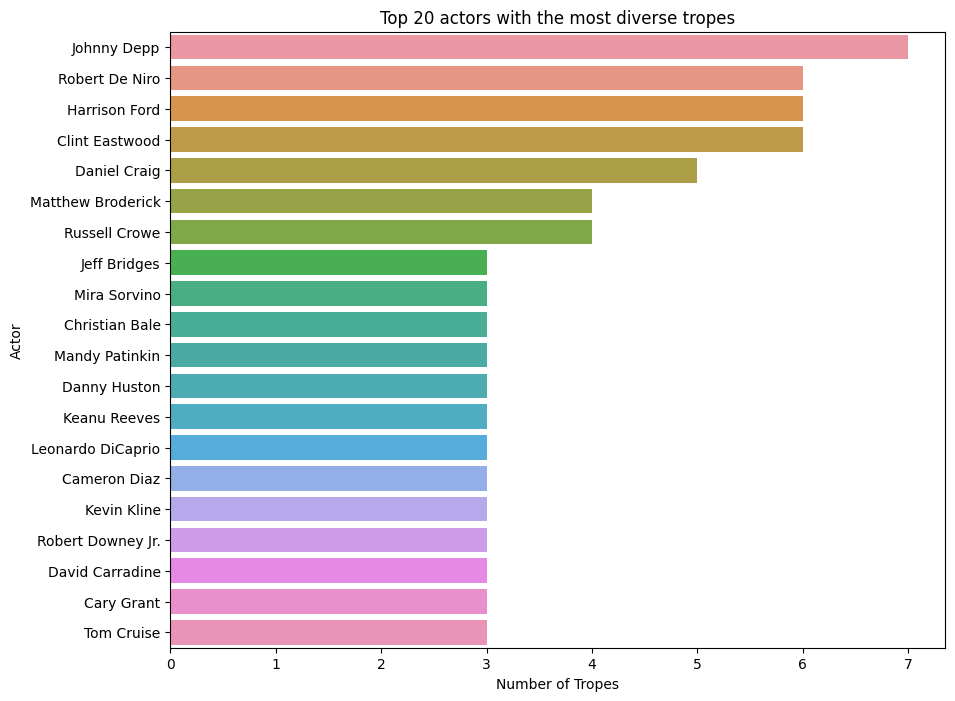

In [111]:
plt.figure(figsize=(10, 8))
sns.barplot(data = tvtropes_per_actor.head(20), x="num_tropes", y="actor", orient='h')
plt.xlabel('Number of Tropes')
plt.ylabel('Actor')
plt.title('Top 20 actors with the most diverse tropes')
plt.show()

As we can see we have a problem. We only have very few well known actors with multiple personas. This makes further analysis impossible with this dataset

### Preference Metric

As describe in the [`README.md`](./README.md#methods), we need a **preference metric** per actor. This metric should measure the tendency for a given actor $A$ to have a preferred trope (or set of tropes). A naïve approach would be to compare the distribution of a given actor $A$ to the uniform distribution of tropes. However a rapid analysis show us that the global tropes distribution is not uniform (and as such a more meaningful metric should be determined).



A more meaningfull metric need to be extracted

- **Cross Entropy based metric**:
    
    $$f(\text{Actor}) = \frac{ H(\text{Persona}) }{ H(\text{Persona} | \text{Actor})}$$
    
    This metric has the following property
    - If the actor $A$ always plays the same persona, then $f(A) = +\infty$
    - If the actor $A$ plays each persona randomly (same distribution than the global distribution), then $f(A) = 1$

In [164]:
# Implementation of the cross entropy per actors
tvtropes_per_actor_filtered = tvtropes_per_actor[tvtropes_per_actor["num_tropes"] > 3].copy()
tvtropes_per_actor_filtered

def compute_entropy(array_like):
    array_like = list(array_like)
    dic = {}
    for elem in array_like:
        dic[elem] = dic.get(elem, 0) + 1
    occurences = np.array(list(dic.values()))
    probabilities = occurences / np.sum(occurences)
    return -np.dot(np.log2(probabilities), probabilities)

H_global = compute_entropy(tvtropes_per_actor_filtered['trope'].sum())

tvtropes_per_actor_filtered['cross_entropy_based'] = H_global / tvtropes_per_actor_filtered['trope'].apply(compute_entropy)
tvtropes_per_actor_filtered.head()

,actor,trope,num_tropes,cross_entropy_based
166,Johnny Depp,"[casanova, charmer, byronic_hero, byronic_hero...",7,1.598494
279,Robert De Niro,"[crazy_jealous_guy, crazy_jealous_guy, tranqui...",6,1.756055
109,Harrison Ford,"[charmer, bounty_hunter, loveable_rogue, trick...",6,1.827315
57,Clint Eastwood,"[retired_outlaw, heartbroken_badass, bounty_hu...",6,1.743254
64,Daniel Craig,"[cultured_badass, heartbroken_badass, charmer,...",5,1.893194


- **Mutual Information**:

    $$f(\text{Actor}) = \frac{I(\text{Persona}, \text{Actor})}{H(\text{Persona})} = \frac{ H(\text{Persona}) - H(\text{Persona} | \text{Actor}) }{H(\text{Persona})}$$

    This metric has the following property
    - If the actor $A$ always plays the same persona, then $f(A) = 1$
    - If the actor $A$ plays each persona randomly (same distribution than the global distribution), then $f(A) = 0$

In [ ]:
tvtropes_per_actor_filtered['mutual_information_based'] = tvtropes_per_actor_filtered['trope'].apply(compute_mutual_information) / H_global
tvtropes_per_actor_filtered.head()

### Analyse frequency of tropes when joined with our movies
This merging step is far from perfect as we have to merge on movie name, which is not a primary key. The generated data is widely unreliable, but we still plot it to get an idea of the distribution of personas.

In [48]:
tvtropes_personas_std = tvtropes_personas.copy()
tvtropes_personas_std['movie_name_standardized'] = tvtropes_personas_std['movie_name'].str.lower()

movies_std = movies.copy()
movies_std['movie_name_standardized'] = movies_std['movie_name'].str.lower()

movies_personas = movies_std.merge(tvtropes_personas_std, on='movie_name_standardized', how='inner')

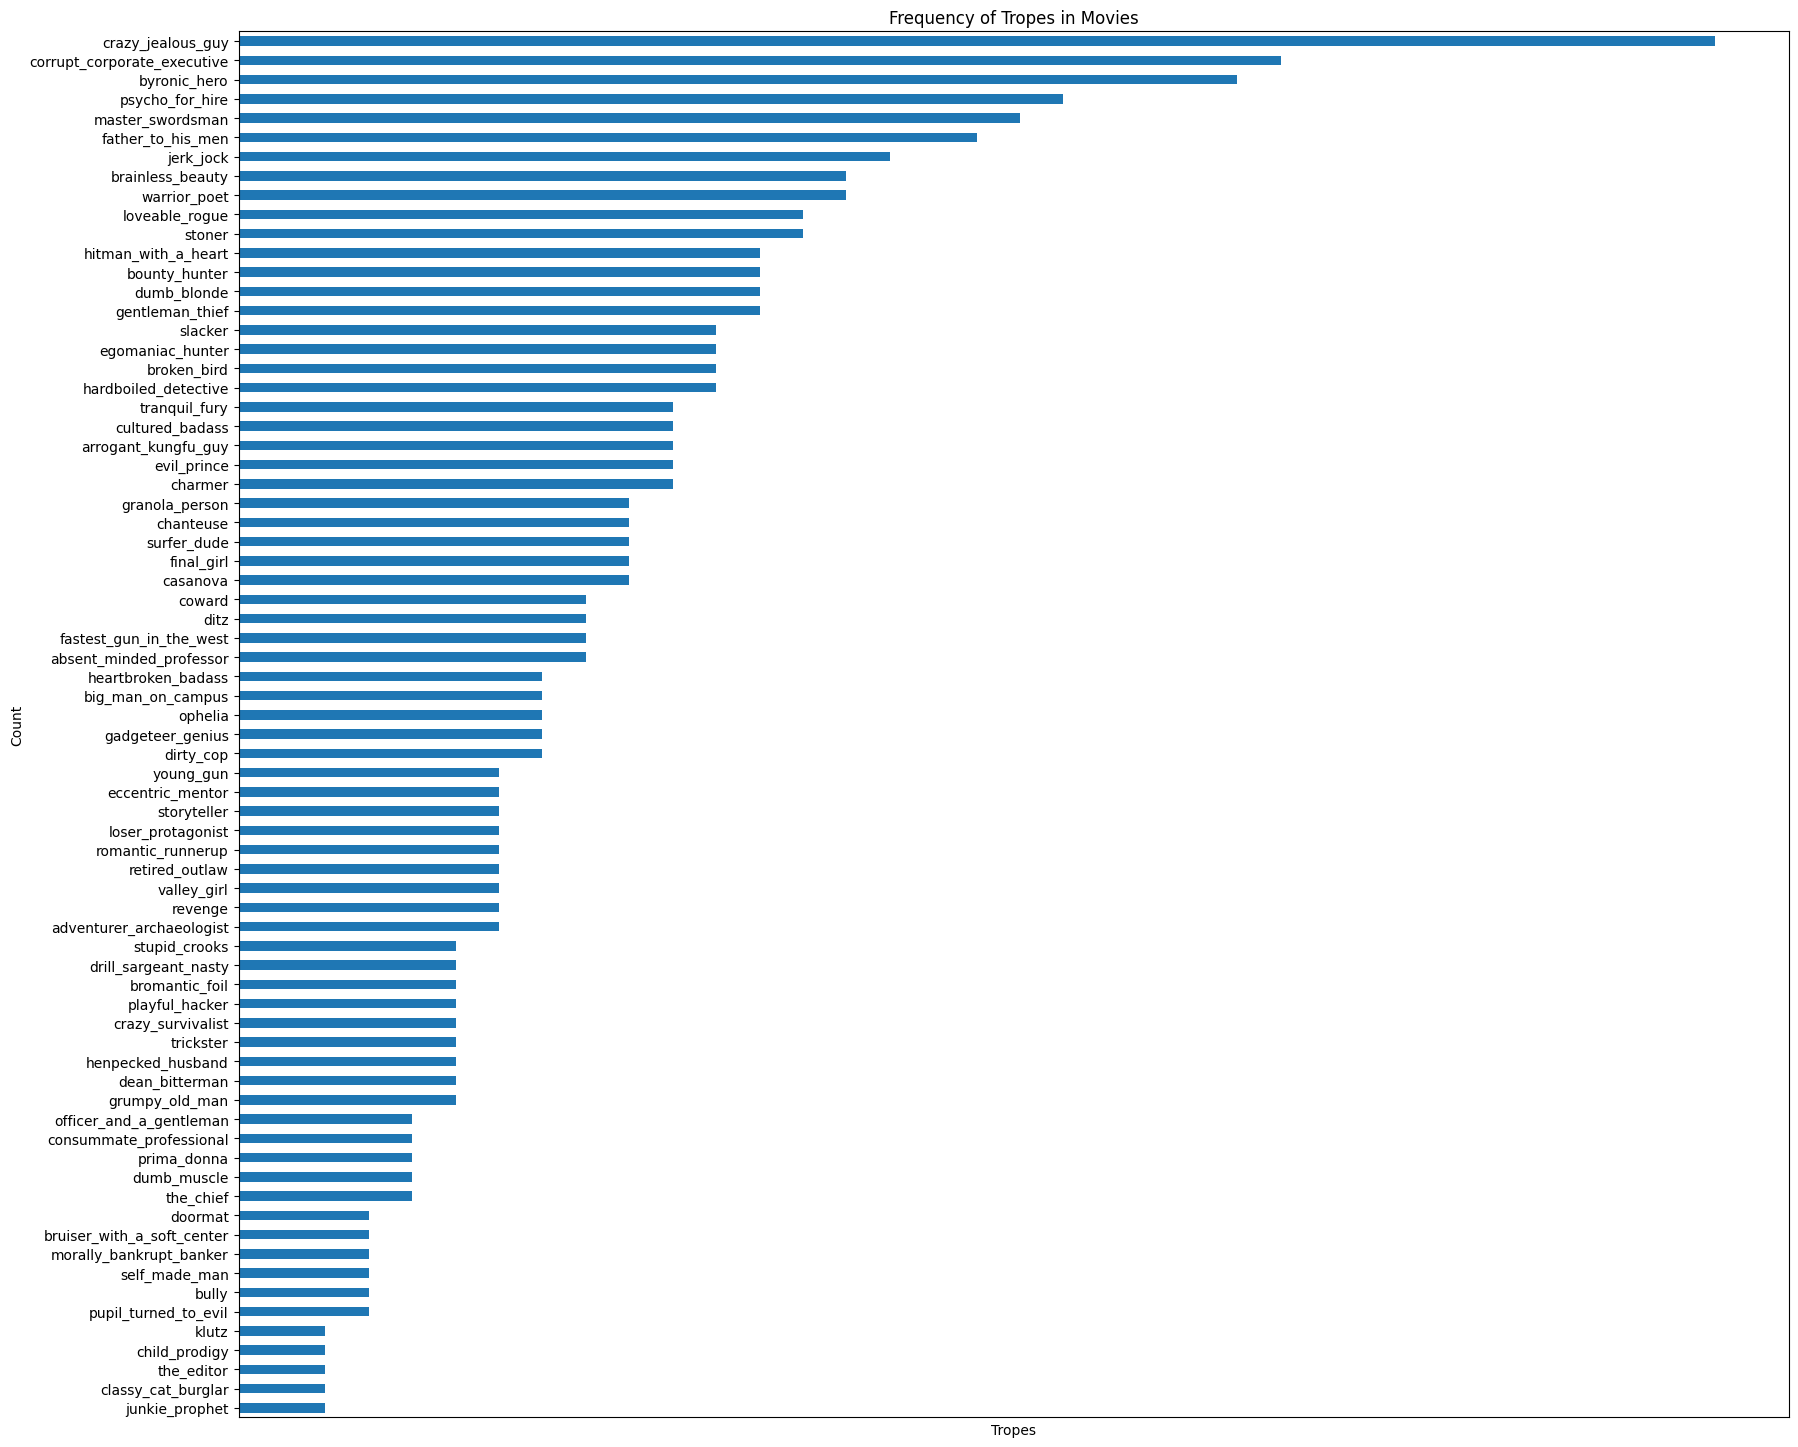

In [102]:
trope_value_counts = movies_personas['trope'].value_counts()

plt.figure(figsize=(20, 18))
trope_value_counts.plot(kind='barh', xticks=[])
plt.xlabel('Tropes')
plt.ylabel('Count')
plt.title('Frequency of Tropes in Movies')
plt.gca().invert_yaxis()
plt.show()

## CMU personas with characters
We merge the actors and characters information we extracted in part I with the personas from the original paper

In [50]:
cmu_personas = load_personas()
cmu_personas.sample(5)

,freebase_id,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib
89486,/m/0c05cqp,27425045,Kalyanaraman,Gauri,Gauri,10,3,"[0.0, 0.0, 0.02, 0.48, 0.0, 0.0, 0.0, 0.0, 0.0..."
127994,e3,4055486,Being from Another Planet,king,the ancient Egyptian king Tutankhamun,4,1,"[0.0, 0.93, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.0..."
170609,e20,887388,Dragonslayer,king,The King,8,30,"[0.0, 0.19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1634,e15,10272267,The Babe,he,him,3,17,"[0.0, 0.0, 0.18, 0.0, 0.0, 0.02, 0.01, 0.0, 0...."
141544,e0,536521,Creepshow,he,A young boy named Billy,4,1,"[0.0, 0.61, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0..."


In [51]:
movies_personas_cmu = cmu_personas.merge(actors_characters, left_on='freebase_id', right_on='freebase_map_id')

In [52]:
movies_personas_cmu.sample(5)

,freebase_id_x,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib,nconst,knownForTitles,...,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
10755,/m/0k3z_f,74984,Suspicion,Johnnie,Johnnie,23,49,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm0000026,"tt0053125,tt0038787,tt0034248,tt0056923",...,1941-11-14,1904-01-18,M,1.870,None,Cary Grant,37.0,/m/0k3z_f,/m/0ch9txr,/m/09qh1
5833,/m/0gb2yp0,27296052,The Lamp Still Burns,Laurence Rains,He,3,2,"[0.0, 0.01, 0.43, 0.07, 0.0, 0.0, 0.0, 0.0, 0....",nm0001289,"tt0042646,tt0048087,tt0045125,tt0045053",...,1943,1913-05-06,M,1.900,None,Stewart Granger,29.0,/m/0gb2yp0,/m/0h5nlzz,/m/026d77
599,/m/09j015v,11481973,Lakshyam,Section Shankar,He,7,29,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0,...",nm1004985,"tt0169102,tt0373856,tt8377874,tt1954470",...,2007-07-06,1967-01-01,M,NaN,/m/0dryh9k,Yashpal Sharma,40.0,/m/09j015v,/m/0h6mzvd,/m/0fwfxv
9837,/m/02vbr8d,6196826,Treasure Island,Jim Hawkins,Jim,106,44,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm0237985,"tt0038969,tt0042046,tt0043067,tt0046183",...,1950-06-22,1937-03-03,M,NaN,None,Bobby Driscoll,13.0,/m/02vbr8d,/m/057y48p,/m/03d9sf
9217,/m/0jxb_w,5456819,Disturbia,Kale Brecht,Kale and Julie,25,41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm0479471,"tt0418279,tt4364194,tt2713180,tt8151874",...,2007-04-04,1986-06-11,M,1.759,/m/041rx,Shia LaBeouf,20.0,/m/0jxb_w,/m/05vc9vc,/m/04w391


In [53]:
print(f"We have {len(movies_personas_cmu)} records for characters")

We have 11985 records for characters


This offers us one possiblity for further analysis, as we have more than 10'000 records

## Movie-based comfort zones
We investigate the possiblity of coming up with comfort zones by analysing movie features for a given actor

In [54]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,Romance,5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"Documentary,News,Sport",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"Action,Adventure,Biography",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",None
4,tt0000679,120,"Adventure,Fantasy",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",None


In [55]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0025164,"[""Guy Holden""]",/m/0glnm,61169,1934,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0,/m/0h953
1,nm0002143,"tt0057193,tt0036613,tt0030241,tt0027125",tt0025164,"[""Egbert 'Pinky' Fitzgerald""]",/m/0glnm,61169,1934,1886-03-18,M,NaN,None,Edward Everett Horton,NaN,/m/0cs6brt,None,/m/0197p7
2,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0026942,"[""Huck Haines""]",/m/02x5h46,12800555,1935-03-08,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z,/m/0h953
3,nm0000068,"tt0056412,tt0026942,tt0029284,tt0046375",tt0026942,"[""John Kent""]",/m/02x5h46,12800555,1935-03-08,1898-01-23,M,1.905,None,Randolph Scott,NaN,/m/03l20fw,/m/0h2qky5,/m/014y_c
4,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0027125,"[""Jerry Travers""]",/m/0gnjh,61501,1935,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5,/m/0h953


In [58]:
all_data = movies.merge(actors_characters, how="inner", on=["tconst", "freebase_id", "wiki_movie_id"])
all_data.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,...,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,tt0000574,70,"Action,Adventure,Biography",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,1906-12-26,1871,M,NaN,None,John Tait,NaN,/m/0k6ktp,None,/m/0k6ksg
1,tt0000574,70,"Action,Adventure,Biography",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,1906-12-26,1880,M,NaN,None,Nicholas Brierley,NaN,/m/0k6ktc,None,/m/0k6ks2
2,tt0000574,70,"Action,Adventure,Biography",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,1906-12-26,\N,None,NaN,None,Norman Campbell,NaN,/m/0bxl4zk,None,/m/0bxl4z5
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,...,1907-06-20,\N,M,NaN,None,Henri Gouget,NaN,/m/0n5_12f,None,/m/0n5_12j
4,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,...,1907-06-20,1874-01-14,M,NaN,None,Georges Wague,NaN,/m/0n5_11r,None,/m/0n5_11v


In [59]:
all_data.columns

Index(['tconst', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'freebase_id', 'wiki_movie_id', 'movie_name', 'movie_release_date',
       'box_office', 'movie_languages', 'movie_countries', 'movie_genres',
       'plot_summary', 'nconst', 'knownForTitles', 'characters',
       'release_date', 'actor_birth', 'actor_gender', 'actor_height',
       'actor_ethnicity', 'actor_name', 'release_actor_age', 'freebase_map_id',
       'freebase_character_id', 'freebase_actor_id'],
      dtype='object')

### Based on movie genre

In [60]:
movie_genre_per_actor = all_data[["nconst", "actor_name", "movie_genres"]].copy()
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["movie_genres"].apply(lambda genres: list(genres.values()))
movie_genre_per_actor = movie_genre_per_actor.drop("movie_genres", axis=1)
movie_genre_per_actor = movie_genre_per_actor.groupby(["nconst", "actor_name"]).agg(list).reset_index()
movie_genre_per_actor["total_movies"] = movie_genre_per_actor["genres_flattened"].apply(len)
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: [item for row in ls for item in row])
movie_genre_per_actor["genres_freq"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: dict(sorted(dict(Counter(ls)).items(), key=lambda item: item[1], reverse=True)))
movie_genre_per_actor = movie_genre_per_actor.drop("genres_flattened", axis=1)

In [64]:
movie_genre_per_actor.head()

,nconst,actor_name,total_movies,genres_freq
0,nm0000001,Fred Astaire,33,"{'Musical': 28, 'Comedy': 20, 'Romance Film': ..."
1,nm0000004,John Belushi,6,"{'Comedy': 6, 'Action/Adventure': 3, 'Action':..."
2,nm0000007,Humphrey Bogart,68,"{'Drama': 52, 'Black-and-white': 41, 'Crime Fi..."
3,nm0000008,Marlon Brando,38,"{'Drama': 24, 'Romance Film': 9, 'Action/Adven..."
4,nm0000009,Richard Burton,48,"{'Drama': 37, 'Romance Film': 15, 'War film': ..."


#### Distribution of some actors

C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use is

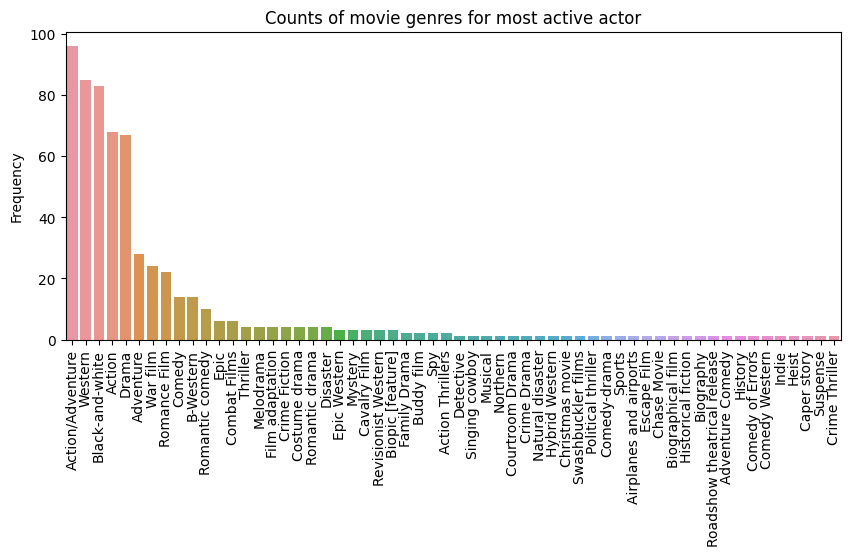

In [61]:
top_actors = movie_genre_per_actor.sort_values("total_movies", ascending=False).copy().head()
actor_1 = top_actors["genres_freq"].iloc[0]

plt.figure(figsize=(10, 4))
plt.title('Counts of movie genres for most active actor')
sns.barplot(x=list(actor_1.keys()), y=list(actor_1.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [62]:
actor_2 = top_actors["genres_freq"].iloc[1]

C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use is

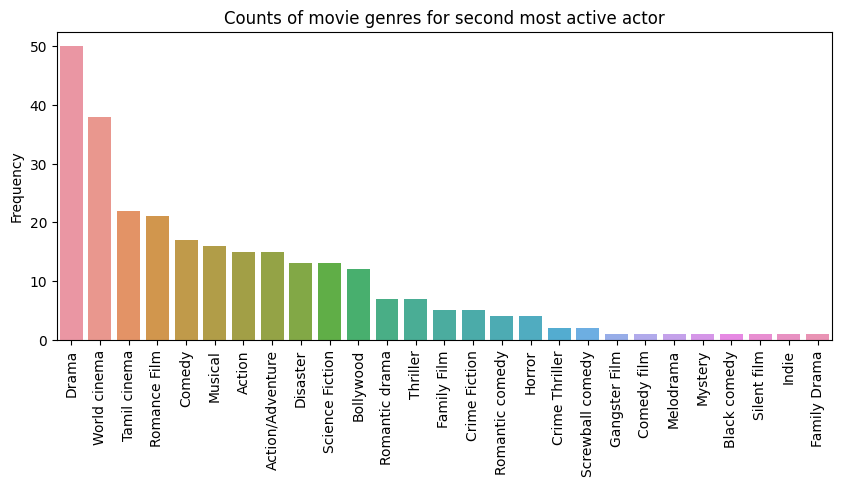

In [63]:
plt.figure(figsize=(10, 4))
plt.title('Counts of movie genres for second most active actor')
sns.barplot(x=list(actor_2.keys()), y=list(actor_2.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

### Based on runtime minutes

In [64]:
runtime_per_actor = all_data[["nconst", "actor_name", "runtimeMinutes"]].copy()

In [65]:
runtime_per_actor = runtime_per_actor[runtime_per_actor["runtimeMinutes"] != "\\N"]

In [66]:
runtime_per_actor = runtime_per_actor.groupby(["nconst", "actor_name"]).agg(list).reset_index()

In [67]:
runtime_per_actor["runtimeMinutes"] = runtime_per_actor["runtimeMinutes"].apply(lambda ls: list(map(lambda elem: int(elem), ls)))

In [68]:
runtime_per_actor['len'] = runtime_per_actor['runtimeMinutes'].apply(len)
runtime_per_actor = runtime_per_actor.sort_values(by='len', ascending=False).drop(columns='len')

#### Distribution of some actors

C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


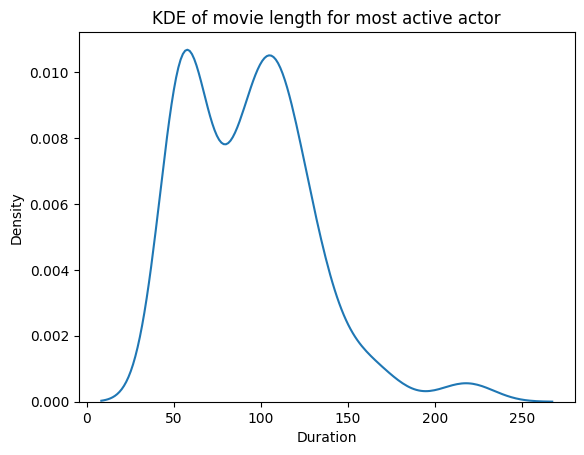

In [69]:
plt.title('KDE of movie length for most active actor')
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[0])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()

C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\guill\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


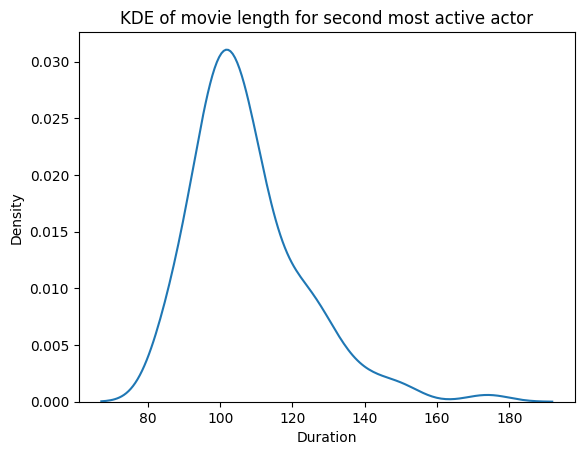

In [70]:
plt.title('KDE of movie length for second most active actor')
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[1])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()